In [4]:
import pandas as pd
#!pip install vaderSentiment
import vaderSentiment

In [8]:
# Load reviews dataset
health_df = pd.read_csv("healthcare_reviews.csv")
infra_df = pd.read_csv("infrastructure_reviews.csv")

# Quick checks
print("Health:", health_df.shape)
print("Infrastructure:", infra_df.shape)

Health: (70777, 20)
Infrastructure: (16734, 20)


In [5]:
# define a function to compute sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def compute_sentiment(text):
    if pd.isna(text):
        return None
    return analyzer.polarity_scores(text)["compound"]

In [6]:
# create sentiment columns for both datasets
def add_sentiment_columns(df):
    df = df.copy()

    # sentiment for pros
    df["sent_pros"] = df["pros"].apply(compute_sentiment)

    # sentiment for cons
    df["sent_cons"] = df["cons"].apply(compute_sentiment)

    # overall sentiment (concatenate available fields)
    df["all_text"] = (
        df["pros"].fillna("") + " " +
        df["cons"].fillna("") + " " +
        df.get("advice", "").fillna("")
    )

    df["sent_overall"] = df["all_text"].apply(compute_sentiment)

    return df

In [9]:
# apply to healthcare and infrastructure
health_sent = add_sentiment_columns(health_df)
infra_sent = add_sentiment_columns(infra_df)

In [10]:
# look at the results
health_sent[["sent_pros", "sent_cons", "sent_overall"]].describe()

,sent_pros,sent_cons,sent_overall
count,70777.000000,70777.000000,70777.000000
mean,0.542033,-0.076469,0.427260
std,0.334324,0.405898,0.478615
min,-0.959600,-0.996600,-0.996300
25%,0.381800,-0.361200,0.153100
50%,0.624900,0.000000,0.588100
75%,0.802000,0.104500,0.807400
max,0.998200,0.998200,0.998900


In [11]:
infra_sent[["sent_pros", "sent_cons", "sent_overall"]].describe()

,sent_pros,sent_cons,sent_overall
count,16734.000000,16734.000000,16734.000000
mean,0.559649,-0.023610,0.485043
std,0.308970,0.388481,0.424284
min,-0.935200,-0.996800,-0.993600
25%,0.421500,-0.296000,0.273200
50%,0.624900,0.000000,0.624900
75%,0.802000,0.202300,0.812600
max,0.995400,0.992600,0.996700


In [12]:
# compare the two industries
health_mean = health_sent["sent_overall"].mean()
infra_mean = infra_sent["sent_overall"].mean()

health_mean, infra_mean

(0.42726007883917094, 0.4850426257918011)

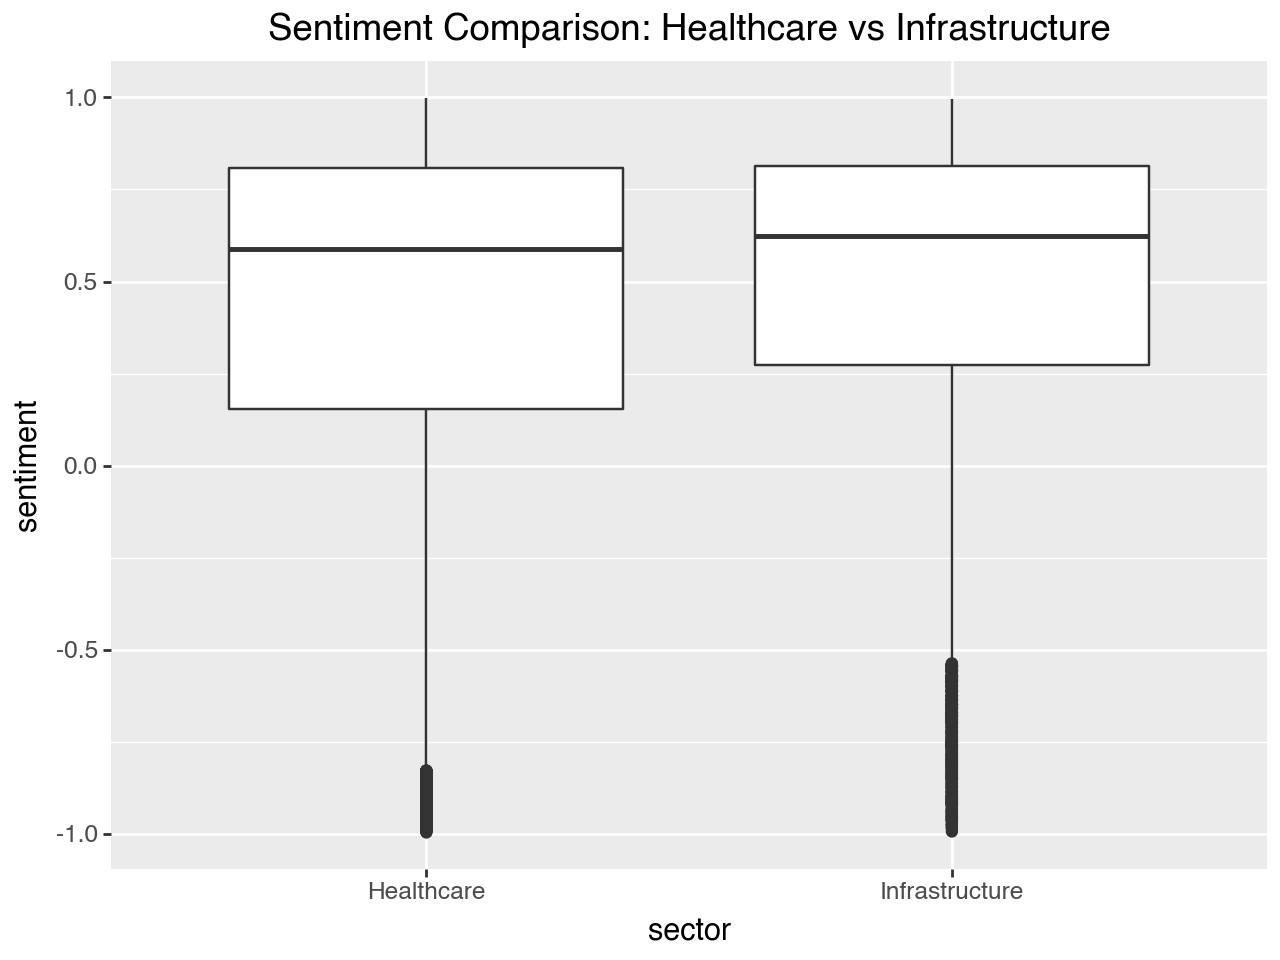

In [13]:
# visualize
from plotnine import *

combined = pd.DataFrame({
    "sector": ["Healthcare"] * len(health_sent) + ["Infrastructure"] * len(infra_sent),
    "sentiment": pd.concat([health_sent["sent_overall"], infra_sent["sent_overall"]], ignore_index=True)
})

(
    ggplot(combined, aes(x="sector", y="sentiment"))
    + geom_boxplot()
    + labs(title="Sentiment Comparison: Healthcare vs Infrastructure")
)

In [14]:
def add_title_sentiment(df):
    """
    Adds a sentiment score for the 'title' column of a DataFrame.
    Creates a new column 'sent_title'.
    """
    df = df.copy()
    df["sent_title"] = df["title"].apply(compute_sentiment)
    return df

In [15]:
health_df = add_title_sentiment(health_df)
infra_df  = add_title_sentiment(infra_df)

In [17]:
health_title_mean = health_df["sent_title"].mean()
infra_title_mean = infra_df["sent_title"].mean()

health_title_mean, infra_title_mean

(0.18829678551136364, 0.23718711671167117)

In [18]:
# convert date columns to date time
health_df["date"] = pd.to_datetime(health_df["date"], errors="coerce")
infra_df["date"]  = pd.to_datetime(infra_df["date"], errors="coerce")

In [19]:
# extract year
health_df["year"] = health_df["date"].dt.year
infra_df["year"]  = infra_df["date"].dt.year

In [20]:
# compute average sentiment per year
health_yearly = (
    health_df.groupby("year")["sent_title"]
    .mean()
    .reset_index()
    .assign(group="Healthcare")
)

infra_yearly = (
    infra_df.groupby("year")["sent_title"]
    .mean()
    .reset_index()
    .assign(group="Infrastructure")
)

sent_over_time = pd.concat([health_yearly, infra_yearly], ignore_index=True)

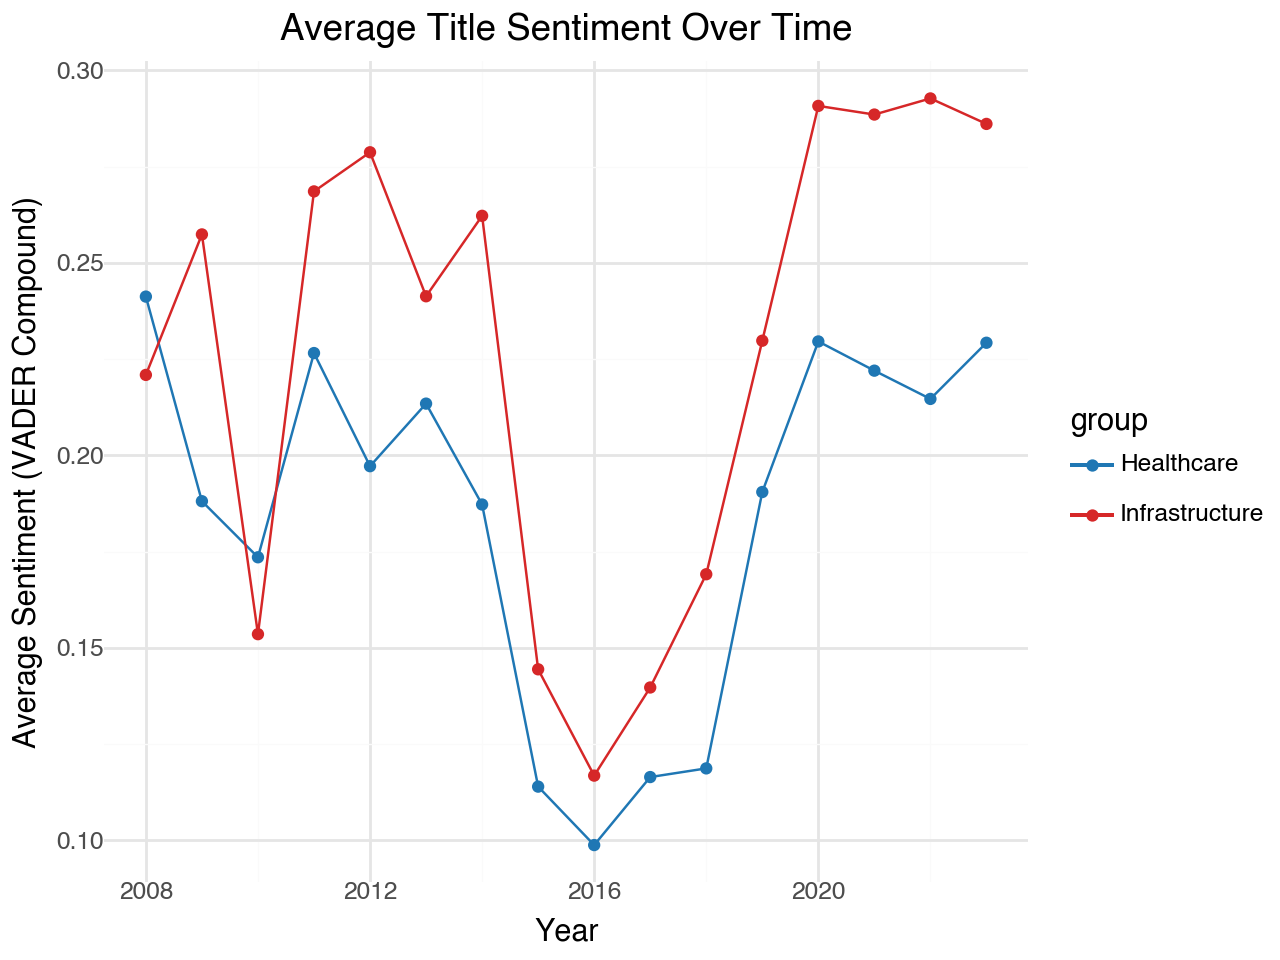

In [22]:
# visualize
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal

(
    ggplot(sent_over_time, aes(x="year", y="sent_title", color="group"))
    + geom_line()
    + geom_point()
    + scale_color_manual(values={
        "Healthcare": "#1f77b4",
        "Infrastructure": "#d62728"})
    + labs(
        title="Average Title Sentiment Over Time",
        x="Year",
        y="Average Sentiment (VADER Compound)")
    + theme_minimal()
)